# 학습 결과

user1의 scene 1~3만 사용해서 학습

scene보다 user가 많기 때문에 데이터의 양이 확연히 줄어듬에도 불구하고 성능이 괜찮음.  
적은 데이터 특화됐기 때문인지는 모르겠다.

나머지 scene에 대해서도 잘 학습을 하면서 user에 대해서도 특화된다면 성능을 상당히 끌어올릴 수 있을 것으로 기대됨.  
--> curriculum learning

In [6]:
from multiprocessing import cpu_count
from pathlib import Path
from typing import List, Union, AnyStr
from math import pi
import pickle

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn import model_selection
from tqdm import tqdm
import torch_optimizer
from torch.utils.data import Dataset
import pandas as pd
import random

import torch_burn as tb
import utils

In [7]:
tb.seed_everything(0)

In [8]:
EXPERIMENT_NAME = '1130-Scene3-CLSTMC-win120'
CHECKPOINT_DIR = Path('checkpoint', EXPERIMENT_NAME)
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

DATA_DIR = Path('data/1116')
TRAIN_FILES = sorted(list(DATA_DIR.glob('*scene3_0.csv')))
TEST_FILES = sorted(list(DATA_DIR.glob('*scene3_1.csv')))

# 데이터셋 생성

scene1에 대해서 모든 user의 데이터를 하나로 합친다.

In [9]:
WINDOW_SIZE = 120

In [10]:
class CSVSequentialDataset(Dataset):
    def __init__(self, csvfile, window_size, stride):
        super(CSVSequentialDataset, self).__init__()

        self.xcols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll',
                      'acceleration_x', 'acceleration_y', 'acceleration_z']
        self.ycols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll']

        self.csv = pd.read_csv(csvfile)
        self.window_size = window_size
        
        self.indexes = []
        i = 0
        while i <= len(self.csv) - window_size * 2:
            self.indexes.append((i, i + window_size))
            i += stride

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, idx):
        sx, tx = self.indexes[idx]
        sy, ty = sx + WINDOW_SIZE, tx + WINDOW_SIZE
        x = self.csv.iloc[sx:tx][self.xcols].to_numpy()
        y = self.csv.iloc[sy:ty][self.ycols].to_numpy()

        x = torch.tensor(x, dtype=torch.float32) # 300, 6
        y = torch.tensor(y, dtype=torch.float32) # 300, 3

        return x, y

In [11]:
ds_train = [CSVSequentialDataset(f, window_size=WINDOW_SIZE, stride=5) for f in TRAIN_FILES]
ds_train = tb.data.ChainDataset(*ds_train)
ds_test = [CSVSequentialDataset(f, window_size=WINDOW_SIZE, stride=5) for f in TEST_FILES]
ds_test = tb.data.ChainDataset(*ds_test)

In [12]:
len(ds_train), len(ds_test)

(11071, 10671)

In [13]:
ds_train[0][0].shape, ds_train[0][1].shape

(torch.Size([120, 6]), torch.Size([120, 3]))

In [14]:
x, y = ds_train[0]

In [15]:
x.shape, y.shape

(torch.Size([120, 6]), torch.Size([120, 3]))

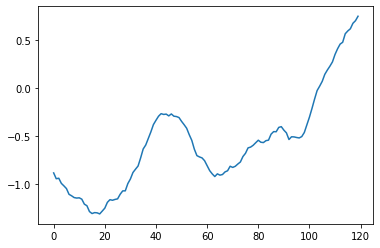

In [16]:
plt.plot(x[:, 2])

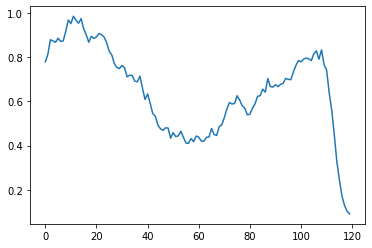

In [17]:
plt.plot(y[:, 2])

# 모델 생성

In [18]:
class ResBlock1d(nn.Module):
    def __init__(self, inchannels, channels, kernel_size):
        super(ResBlock1d, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv1d(inchannels, channels, kernel_size, padding=kernel_size // 2),
            nn.BatchNorm1d(channels),
            nn.LeakyReLU(),
            nn.Conv1d(channels, channels, kernel_size, padding=kernel_size // 2),
            nn.BatchNorm1d(channels)
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(inchannels, channels, 1),
            nn.BatchNorm1d(channels)
        )
        self.act = nn.LeakyReLU()

    def forward(self, x):
        identity = x

        x = self.conv1(x)
        identity = self.conv2(identity)
        x += identity
        x = self.act(x)

        return x

In [19]:
class CLSTMC(nn.Module):
    def __init__(self):
        super(CLSTMC, self).__init__()

        self.conv_in = nn.Sequential(
            nn.Conv1d(6, 24, 3, padding=1, groups=2),
            nn.BatchNorm1d(24),
            nn.LeakyReLU(),
            nn.Conv1d(24, 48, 3, padding=1, groups=2),
            nn.BatchNorm1d(48),
            nn.LeakyReLU(),
            nn.Conv1d(48, 64, 3, padding=1),
            nn.BatchNorm1d(64),
        )

        self.rnn = nn.LSTM(input_size=64,
                           hidden_size=64,
                           num_layers=6,
                           batch_first=True,
                           dropout=0,
                           bidirectional=True)

        self.conv_out = nn.Sequential(
            ResBlock1d(128, 64, 3),
            nn.Conv1d(64, 3, 1)
        )

    def forward(self, x):
        x = x.transpose(1, 2)  # B, S, 6 --> B, 6, S
        x = self.conv_in(x)  # B, 6, S
        x = x.transpose(1, 2)  # B, S, 6

        outs, (hiddens, cells) = self.rnn(x)  # B, S, 128
        x = outs.transpose(1, 2)  # B, 128, S
        x = self.conv_out(x) # (B, 3, S)
        x = x.transpose(1, 2) # (B, S, 3)

        return x

In [20]:
model = CLSTMC().cuda()

In [21]:
criterion = nn.MSELoss().cuda()
optimizer = torch_optimizer.RAdam(model.parameters())

In [22]:
class HPMetric(tb.metrics.InvisibleMetric):
    def __init__(self, name: str):
        super(HPMetric, self).__init__(name)

        self.diff = []

    def on_valid_epoch_end(self, epoch: int, logs: dict):
        # RMS, 99% tile 출력
        yaw_v, pitch_v, roll_v, rms_v, tile99_v = self._calc_values(self.diff)

        print(f'                  validation')
        print(f' - Yaw          : {yaw_v:10f}')
        print(f' - Pitch        : {pitch_v:10f}')
        print(f' - Roll         : {roll_v:10f}')
        print(f' - RMS          : {rms_v:10f}')
        print(f' - 99% Tile     : {tile99_v:10f}')

        self.diff.clear()

    def get_value(self, outputs: torch.Tensor, targets: torch.Tensor, is_train: bool):
        if not is_train:
            self.diff.append((outputs - targets).mean(1).detach().cpu())  # (B, S, 3) --> (B, 3)

    @staticmethod
    def _calc_values(diff):
        diff = torch.cat(diff).abs_()  # (D, 3)
        rms = (diff.square().sum(1) / 3).sqrt()
        tile = rms.flatten().numpy()
        tile99 = np.percentile(tile, 99)
        
        mrms = rms.mean()
        
        # diff = radian2degree(diff)
        #tile = diff.flatten().numpy()
        #tile99 = np.percentile(tile, 99)

        mdiff = diff.mean(dim=0)
        #rms = (mdiff.square().sum() / 3).sqrt()

        return mdiff[0].item(), mdiff[1].item(), mdiff[2].item(), mrms.item(), tile99

In [23]:
metrics = [tb.metrics.ModuleMetric(criterion, 'loss'),
           HPMetric('hp_metric')]

In [24]:
callbacks = [tb.callbacks.EarlyStopping(metrics[0]),
             tb.callbacks.LRDecaying(optimizer, metrics[0], patience=3),
             tb.callbacks.SaveCheckpoint({'model': model}, metrics[0], CHECKPOINT_DIR, 'best-ckpt.pth')]

In [25]:
trainer = tb.Trainer(model, optimizer, metrics, callbacks, ncols=100)

In [26]:
trainer.fit(ds_train, ds_test, num_epochs=200, batch_size=256, shuffle=True, pin_memory=True)

[0002/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from inf to 231.49503744216193
                  validation
 - Yaw          :  17.972843
 - Pitch        :  10.082040
 - Roll         :   2.388203
 - RMS          :  12.897181
 - 99% Tile     :  26.523259


[0003/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 231.49503744216193 to 197.06257238842193
                  validation
 - Yaw          :  16.369272
 - Pitch        :   8.961867
 - Roll         :   2.302773
 - RMS          :  11.671744
 - 99% Tile     :  24.799163


[0004/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 197.06257238842193 to 180.34231667291547
                  validation
 - Yaw          :  15.262565
 - Pitch        :   8.450992
 - Roll         :   2.226398
 - RMS          :  10.932308
 - 99% Tile     :  24.321593


[0005/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :  16.244301
 - Pitch        :   8.637753
 - Roll         :   2.391788
 - RMS          :  11.512520
 - 99% Tile     :  24.464756


[0006/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 180.34231667291547 to 160.58646892365954
                  validation
 - Yaw          :  14.186891
 - Pitch        :   7.910190
 - Roll         :   2.299125
 - RMS          :  10.243835
 - 99% Tile     :  23.036718


[0007/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 160.58646892365954 to 143.44016928899856
                  validation
 - Yaw          :  13.053515
 - Pitch        :   7.177955
 - Roll         :   2.344096
 - RMS          :   9.465163
 - 99% Tile     :  21.814161


[0008/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :  13.806016
 - Pitch        :   7.552896
 - Roll         :   2.328424
 - RMS          :   9.982880
 - 99% Tile     :  22.464838


[0009/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 143.44016928899856 to 139.1925665083386
                  validation
 - Yaw          :  12.355879
 - Pitch        :   6.449583
 - Roll         :   2.458601
 - RMS          :   8.965957
 - 99% Tile     :  23.942063


[0010/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 139.1925665083386 to 124.75905858902703
                  validation
 - Yaw          :  11.046144
 - Pitch        :   6.390404
 - Roll         :   2.285678
 - RMS          :   8.269393
 - 99% Tile     :  21.804310


[0011/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 124.75905858902703 to 120.51941340310233
                  validation
 - Yaw          :  11.432207
 - Pitch        :   5.493495
 - Roll         :   2.481401
 - RMS          :   8.195355
 - 99% Tile     :  21.457893


[0012/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :  11.536886
 - Pitch        :   5.926322
 - Roll         :   2.261967
 - RMS          :   8.252299
 - 99% Tile     :  23.167842


[0013/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 120.51941340310233 to 113.87309687478202
                  validation
 - Yaw          :  11.335725
 - Pitch        :   4.878118
 - Roll         :   2.254167
 - RMS          :   7.881913
 - 99% Tile     :  21.463579


[0014/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 113.87309687478202 to 110.14495736076718
                  validation
 - Yaw          :  10.447905
 - Pitch        :   4.943547
 - Roll         :   2.351621
 - RMS          :   7.509070
 - 99% Tile     :  22.959463


[0015/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 110.14495736076718 to 99.9256896064395
                  validation
 - Yaw          :   9.773612
 - Pitch        :   4.727113
 - Roll         :   2.322831
 - RMS          :   7.066730
 - 99% Tile     :  21.695702


[0016/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   9.742298
 - Pitch        :   4.861022
 - Roll         :   2.260800
 - RMS          :   7.104017
 - 99% Tile     :  21.701638


[0017/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :  10.606799
 - Pitch        :   4.415748
 - Roll         :   2.501481
 - RMS          :   7.434519
 - 99% Tile     :  23.551219


[0018/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Decaying lr from 0.001 to 0.0005 because val_loss did not improved for 3 epochs
val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   9.564279
 - Pitch        :   4.466857
 - Roll         :   2.287360
 - RMS          :   6.882518
 - 99% Tile     :  23.575503


[0019/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :  10.069236
 - Pitch        :   4.207029
 - Roll         :   2.217802
 - RMS          :   7.082671
 - 99% Tile     :  23.629929


[0020/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 5 epochs
                  validation
 - Yaw          :  10.042223
 - Pitch        :   4.133352
 - Roll         :   2.210201
 - RMS          :   7.065847
 - 99% Tile     :  23.848704


[0021/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Decaying lr from 0.0005 to 0.00025 because val_loss did not improved for 3 epochs
val_loss is not improved for 6 epochs
                  validation
 - Yaw          :  10.806696
 - Pitch        :   4.307233
 - Roll         :   2.318144
 - RMS          :   7.500239
 - 99% Tile     :  23.189077


[0022/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 7 epochs
                  validation
 - Yaw          :  10.157089
 - Pitch        :   4.496960
 - Roll         :   2.219310
 - RMS          :   7.193200
 - 99% Tile     :  24.238558


[0023/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 8 epochs
                  validation
 - Yaw          :  10.486484
 - Pitch        :   4.121784
 - Roll         :   2.252669
 - RMS          :   7.257137
 - 99% Tile     :  23.960945


[0024/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Decaying lr from 0.00025 to 0.000125 because val_loss did not improved for 3 epochs
val_loss is not improved for 9 epochs
                  validation
 - Yaw          :  10.643313
 - Pitch        :   4.184698
 - Roll         :   2.171547
 - RMS          :   7.378360
 - 99% Tile     :  25.452780


[0024/0200] Validation: 100%|████████████████████| 42/42 [00:02<00:00, 17.62it/s, val_loss 117.6397]

val_loss is not improved for 10 epochs
Stop training because val_loss did not improved for 10 epochs
                  validation
 - Yaw          :  10.749284
 - Pitch        :   4.063399
 - Roll         :   2.267335
 - RMS          :   7.396717
 - 99% Tile     :  25.646337
